# View Masks

In [10]:
# load in text file and read matrix shape
import numpy as np
import cv2

path_to_flower_mask = '/group/bnbaileygrp/bnbailey/Syn2Real_cowpea_flowermap/camA/camA_cowpea_045_007_4363588_closedflowerID.txt'
path_to_image = '/group/bnbaileygrp/bnbailey/Syn2Real_cowpea_flowermap/camA/camA_cowpea_045_007_3522028_RGB.jpeg'

mask_raw = np.loadtxt(path_to_flower_mask)
image = cv2.imread(path_to_image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print(f"Mask Shape: {mask_raw.shape}")
print(f"Image Shape: {image.shape}")
print(f"Data type: {mask_raw.dtype}")

Mask Shape: (2048, 2048)
Image Shape: (2048, 2048, 3)
Data type: float64


In [11]:
import matplotlib.pyplot as plt

# Convert to numpy array if needed
mask_raw = np.array(mask_raw)

# Get unique values and print range
mask_classes = np.unique(mask_raw)
mask_classes = mask_classes[~np.isnan(mask_classes)].astype(int)
print(f"mask unique classes: {mask_classes}")

mask unique classes: [  8320  36386  40801  57619  76094  82934  83148  85580 104307 121847
 136510 189113 204096 206063 215362 226869 226889 230061 239690 270129
 289280 297492 301683 381883 400380 416391 420678 458113 461930 468996
 491005 494455 502953 504328 510177 514138 530324 560493 585198 587906
 594820 633707 664827 674213 689332 728775 757500 763993 779437 784396
 787739 795836 808750 833269 835455 849097 853338 865361 887743 917453
 919704 930140 932272 933832 936320 944436 948887 958135 958616 962204
 982401 996979]


/tmp/ipykernel_1724295/672073113.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('hsv', len(mask_classes))


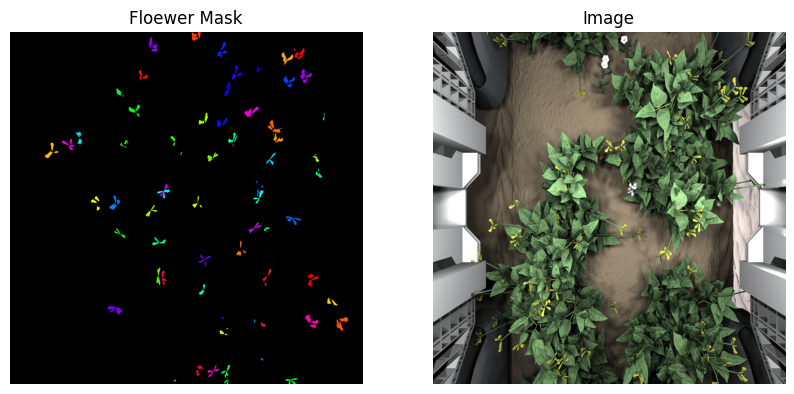

In [12]:
# plot image using class IDs as colors
plt.figure(figsize=(10, 6))

# Create a colormap with a color for each class
cmap = plt.cm.get_cmap('hsv', len(mask_classes))
mask_cmap = {class_id: cmap(i) for i, class_id in enumerate(mask_classes)}

# Create an RGB image using the colormap
mask_rgb = np.zeros((mask_raw.shape[0], mask_raw.shape[1], 3))
for class_id, color in mask_cmap.items():
    mask_rgb[mask_raw == class_id] = color[:3]
  
# show mask, plant and iamge side by side
plt.subplot(1, 2, 1)
plt.imshow(mask_rgb)
plt.axis('off')
plt.title('Floewer Mask')
plt.subplot(1, 2, 2)
plt.imshow(image)
plt.axis('off')
plt.title('Image')
plt.show()

# Preprocessing Example

In [28]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

# ====== Settings ======
# Paths for one image example (you can loop over directories similarly)
path_to_image = '/group/jmearlesgrp/data/AGILE-Datasets/Flower-Detection/Synthetic/new/images_full/camA_cowpea_045_003_7592365_RGB.jpeg'
path_to_bbox  = '/group/jmearlesgrp/data/AGILE-Datasets/Flower-Detection/Synthetic/new/labels_full/camA_cowpea_045_003_7592365_RGB.txt'
path_to_mask  = '/group/jmearlesgrp/data/AGILE-Datasets/Flower-Detection/Synthetic/new/masks_full/camA_cowpea_045_003_7592365_RGB.txt'  # YOLO label file

# Minimum percentage threshold (5% here)
min_pct = 0.2

In [29]:
# ====== Helper: Convert YOLO normalized bbox to absolute pixel coordinates ======
def yolo_to_bbox(yolo_line, image_width, image_height):
    """
    Convert a YOLO-format bounding box (class x_center y_center width height)
    into absolute pixel coordinates.
    Note: The class is parsed but will be ignored for filtering.
    """
    parts = yolo_line.strip().split()
    if len(parts) != 5:
        raise ValueError("Each YOLO label line must have 5 values: class x_center y_center width height")
    
    bbox_class = int(parts[0])
    x_center = float(parts[1])
    y_center = float(parts[2])
    bbox_w = float(parts[3])
    bbox_h = float(parts[4])
    
    xmin = int((x_center - bbox_w/2) * image_width)
    xmax = int((x_center + bbox_w/2) * image_width)
    ymin = int((y_center - bbox_h/2) * image_height)
    ymax = int((y_center + bbox_h/2) * image_height)
    
    return bbox_class, xmin, ymin, xmax, ymax

In [30]:
# ====== Load the image ======
image = cv2.imread(path_to_image)
if image is None:
    raise FileNotFoundError(f"Could not load image from {path_to_image}")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
h, w = image.shape[:2]

# ====== Load the mask ======
# The mask is assumed to be a text file with a matrix of values.
# Any nonzero value in the mask is considered part of the object.
mask = np.loadtxt(path_to_mask)
mask = np.array(mask, dtype=float)  # Ensure mask is a NumPy array

# ====== Read bounding box labels ======
bboxes = []
with open(path_to_bbox, 'r') as f:
    for line in f:
        if line.strip() == '':
            continue
        try:
            bbox = yolo_to_bbox(line, w, h)
            bboxes.append(bbox)
        except ValueError as e:
            print(f"Skipping line: {line}. Error: {e}")

print("Total bounding boxes found:", len(bboxes))

Total bounding boxes found: 109


In [31]:
# ====== Filter bounding boxes based on mask content ======
# For each bbox, we check that at least 5% of the pixels in the bounding box area
# are object pixels (i.e. mask pixel value > 0).
valid_bboxes = []
for bbox in bboxes:
    # We ignore the bbox_class for filtering purposes.
    bbox_class, xmin, ymin, xmax, ymax = bbox

    # Ensure coordinates are within image bounds
    xmin = max(0, xmin)
    ymin = max(0, ymin)
    xmax = min(w, xmax)
    ymax = min(h, ymax)
    
    # Extract the mask region corresponding to the bounding box
    mask_region = mask[ymin:ymax, xmin:xmax]
    total_pixels = mask_region.size
    if total_pixels == 0:
        continue

    # Count object pixels (nonzero in the mask)
    object_pixels = np.sum(mask_region > 0)
    
    frac = object_pixels / total_pixels

    if frac >= min_pct:
        valid_bboxes.append(bbox)
    else:
        print(f"BBox {bbox} filtered out; object fraction: {frac:.3f}")

print("Valid bounding boxes after filtering:", len(valid_bboxes))

BBox (0, 1368, 902, 1428, 967) filtered out; object fraction: 0.175
BBox (0, 672, 375, 722, 433) filtered out; object fraction: 0.068
BBox (0, 1157, 403, 1203, 435) filtered out; object fraction: 0.006
BBox (0, 1706, 296, 1735, 366) filtered out; object fraction: 0.116
BBox (0, 1605, 1023, 1665, 1086) filtered out; object fraction: 0.183
BBox (0, 1591, 1584, 1652, 1623) filtered out; object fraction: 0.129
BBox (0, 1059, 986, 1118, 1048) filtered out; object fraction: 0.198
BBox (0, 1104, 1302, 1150, 1376) filtered out; object fraction: 0.186
BBox (0, 1170, 1494, 1226, 1591) filtered out; object fraction: 0.196
BBox (0, 1212, 1350, 1235, 1386) filtered out; object fraction: 0.088
BBox (0, 1593, 1600, 1622, 1615) filtered out; object fraction: 0.014
Valid bounding boxes after filtering: 98


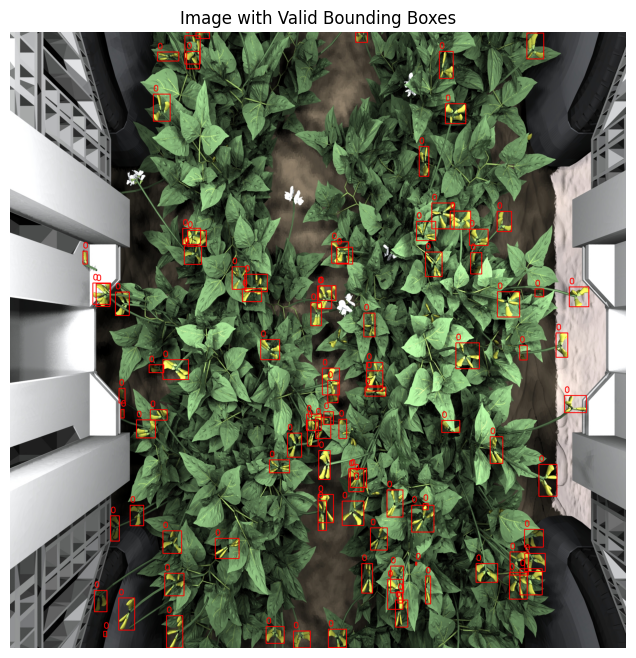

In [32]:
# ====== Visualization ======
# Draw valid bounding boxes on a copy of the image
vis_image = image.copy()
for bbox in valid_bboxes:
    bbox_class, xmin, ymin, xmax, ymax = bbox
    cv2.rectangle(vis_image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
    # Optionally display the class id even though it's ignored in filtering
    cv2.putText(vis_image, str(bbox_class), (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 
                0.9, (255, 0, 0), 2)

plt.figure(figsize=(12, 8))
plt.imshow(vis_image)
plt.axis('off')
plt.title('Image with Valid Bounding Boxes')
plt.show()

# Full preprocessing

In [ ]:
import os
import glob
import numpy as np
import cv2

from tqdm import tqdm

# ====== Folder Paths ======
image_folder = '/group/jmearlesgrp/data/AGILE-Datasets/Flower-Detection/Synthetic/images_full'
bbox_folder  = '/group/jmearlesgrp/data/AGILE-Datasets/Flower-Detection/Synthetic/labels_full'
mask_folder  = '/group/jmearlesgrp/data/AGILE-Datasets/Flower-Detection/Synthetic/masks_full'
output_folder = '/group/jmearlesgrp/data/AGILE-Datasets/Flower-Detection/Synthetic/labels_full_filtered'

os.makedirs(output_folder, exist_ok=True)

min_pct = 0.05  # Minimum fraction (5%) of object pixels required in bbox

# ====== Helper Function ======
def yolo_to_bbox(yolo_line, img_width, img_height):
    """
    Convert a YOLO-format line (class x_center y_center width height) into
    absolute pixel coordinates.
    
    Returns:
      (bbox_class, xmin, ymin, xmax, ymax)
    """
    parts = yolo_line.strip().split()
    if len(parts) != 5:
        raise ValueError("Each YOLO label line must have 5 values.")
    
    bbox_class = parts[0]  # We keep the class in the output even though it is ignored for filtering.
    x_center = float(parts[1])
    y_center = float(parts[2])
    bbox_w = float(parts[3])
    bbox_h = float(parts[4])
    
    xmin = int((x_center - bbox_w / 2) * img_width)
    xmax = int((x_center + bbox_w / 2) * img_width)
    ymin = int((y_center - bbox_h / 2) * img_height)
    ymax = int((y_center + bbox_h / 2) * img_height)
    
    return bbox_class, xmin, ymin, xmax, ymax

# ====== Process Each BBox File ======
bbox_files = glob.glob(os.path.join(bbox_folder, '*.txt'))
print(f"Found {len(bbox_files)} bbox files to process.")

for bbox_file in tqdm(bbox_files):
    # Get the base name without extension (e.g., "camA_cowpea_045_003_7592365_RGB")
    base_name = os.path.splitext(os.path.basename(bbox_file))[0]
    
    # Construct corresponding image and mask file paths.
    # Image: same base name with .jpeg extension (or try .jpg if needed)
    image_path = os.path.join(image_folder, base_name + '.jpeg')
    if not os.path.exists(image_path):
        image_path = os.path.join(image_folder, base_name + '.jpg')
    if not os.path.exists(image_path):
        print(f"Image file for '{base_name}' not found. Skipping.")
        continue

    mask_path = os.path.join(mask_folder, base_name + '.txt')
    if not os.path.exists(mask_path):
        print(f"Mask file for '{base_name}' not found. Skipping.")
        continue

    # ====== Load the Data ======
    # Load image and convert from BGR to RGB.
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image '{image_path}'. Skipping.")
        continue
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_h, img_w = image.shape[:2]

    # Load mask (assumed to be a text file containing a numeric matrix).
    try:
        mask = np.loadtxt(mask_path)
    except Exception as e:
        print(f"Error loading mask '{mask_path}': {e}. Skipping.")
        continue
    mask = np.array(mask, dtype=float)

    # ====== Read and Filter Bounding Boxes ======
    with open(bbox_file, 'r') as f:
        lines = f.readlines()

    valid_lines = []
    for line in lines:
        if line.strip() == '':
            continue
        try:
            bbox_class, xmin, ymin, xmax, ymax = yolo_to_bbox(line, img_w, img_h)
        except Exception as e:
            print(f"Error parsing line in '{bbox_file}': {line.strip()}. Error: {e}")
            continue

        # Clamp coordinates to image boundaries.
        xmin = max(0, xmin)
        ymin = max(0, ymin)
        xmax = min(img_w, xmax)
        ymax = min(img_h, ymax)
        
        # Extract the corresponding mask region.
        mask_region = mask[ymin:ymax, xmin:xmax]
        total_pixels = mask_region.size
        if total_pixels == 0:
            continue

        # Count object pixels: assume any nonzero value in the mask is part of the object.
        object_pixels = np.sum(mask_region > 0)
        frac = object_pixels / total_pixels

        if frac >= min_pct:
            valid_lines.append(line.strip())
        # else:
        #     print(f"{base_name}: BBox '{line.strip()}' filtered out; object fraction: {frac:.3f}")

    # ====== Write Filtered BBoxes to Output Folder ======
    output_path = os.path.join(output_folder, os.path.basename(bbox_file))
    with open(output_path, 'w') as f_out:
        for valid_line in valid_lines:
            f_out.write(valid_line + '\n')
    # print(f"Wrote {len(valid_lines)} valid bboxes for '{base_name}' to '{output_path}'")


Found 254 bbox files to process.


  0%|          | 0/254 [00:00<?, ?it/s]

100%|██████████| 254/254 [01:34<00:00,  2.68it/s]
